In [1]:
#Yankee Stadium MTA Exit Volume Model
#Matt Samelson

#Data from:  http://web.mta.info/developers/turnstile.html

#This dataset shows entry & exit counter values for each turnstile device in each station in the 
#NYC Subway System. 

# Modeling

#I developed a model for 4hr-interval exit count by station to predict MTA exit volume
#at Yankee Stadium.  

#The model utilizes a Random Forest Regressor.  Attempts to simplify to a linear model were
#unsuccessful due to a severe decline in performance (attempts to fit a linear model not shown here)


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import re
from datetime import date, timedelta
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.float_format', lambda x: '%.2f' % x)
%matplotlib inline


In [3]:
#Generate urls for Turnstile data spanning the 2013 Yankee's season

#Create date portion of URL

def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

datelist = []  

for result in perdelta(date(2013, 3, 30), date(2013, 10, 12), timedelta(days=7)):
    datelist.append(str(date.strftime(result, "%y%m%d")))
  
print datelist

['130330', '130406', '130413', '130420', '130427', '130504', '130511', '130518', '130525', '130601', '130608', '130615', '130622', '130629', '130706', '130713', '130720', '130727', '130803', '130810', '130817', '130824', '130831', '130907', '130914', '130921', '130928', '131005']


In [4]:
#print number of files to download

print "Number of Files: %d" %(len(datelist))

Number of Files: 28


In [5]:
#Download Data

names = ['CA','UNIT','SCP', \
         'DATE1','TIME1','DESC1','ENTRIES1','EXITS1', \
         'DATE2','TIME2','DESC2','ENTRIES2','EXITS2', \
         'DATE3','TIME3','DESC3','ENTRIES3','EXITS3', \
         'DATE4','TIME4','DESC4','ENTRIES4','EXITS4', \
         'DATE5','TIME5','DESC5','ENTRIES5','EXITS5', \
         'DATE6','TIME6','DESC6','ENTRIES6','EXITS6', \
         'DATE7','TIME7','DESC7','ENTRIES7','EXITS7', \
         'DATE8','TIME8','DESC8','ENTRIES8','EXITS8']


season_2013_df = pd.DataFrame()

for i in range(0,len(datelist)):
    
    #print "Processing File %d \n" %(i+1)
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"+ \
          datelist[i] + \
          ".txt"
    temp_df = pd.read_csv(url,header=None,names=names)    
    season_2013_df = pd.concat([season_2013_df, temp_df])
    #print "Completed File %d \n" %(i+1)

print "File Download Completed"

File Download Completed


In [6]:
season_2013_df.shape

(838445, 43)

In [7]:
#Reshape data into a format with a single column for each feature

season_2013_df = pd.lreshape(season_2013_df, \
                     {'DATE': ['DATE1', 'DATE2', 'DATE3','DATE4','DATE5','DATE6','DATE7','DATE8'],
                      'TIME': ['TIME1', 'TIME2', 'TIME3','TIME4','TIME5','TIME6','TIME7','TIME8'],
                      'DESC': ['DESC1', 'DESC2', 'DESC3','DESC4','DESC5','DESC6','DESC7','DESC8'],
                      'ENTRIES': ['ENTRIES1', 'ENTRIES2', 'ENTRIES3','ENTRIES4','ENTRIES5','ENTRIES6',\
                                 'ENTRIES7','ENTRIES8'],
                      'EXITS': ['EXITS1', 'EXITS2', 'EXITS3','EXITS4','EXITS5','EXITS6',\
                                'EXITS7','EXITS8']})                          

In [8]:
#Select only Yankee Stadium turnstile data a "Regular' audit intervals

season_2013_df = season_2013_df.loc[(season_2013_df['UNIT']=='R195') & \
                                    (season_2013_df['DESC']=='REGULAR')]

#Convert entries and exits to numeric and date to datetime

season_2013_df['ENTRIES'] = pd.to_numeric(season_2013_df['ENTRIES'],errors='coerce')
season_2013_df['EXITS']  = pd.to_numeric(season_2013_df['EXITS'],errors='coerce')
season_2013_df['DATE'] = pd.to_datetime(season_2013_df['DATE'], errors='coerce')

#The date filter below trims all data that is outside the 2013 baseball season 

season_2013_df = season_2013_df[((season_2013_df['DATE'] > '2013-03-31') & \
                                 (season_2013_df['DATE'] < '2013-10-01'))]

In [9]:
season_2013_df.shape

(40231, 8)

In [10]:
season_2013_df.head()

,CA,SCP,UNIT,DATE,DESC,EXITS,ENTRIES,TIME
40235,N203,00-00-00,R195,2013-04-02,REGULAR,3481106.00,3534078.00,20:22:00
40236,N203,00-00-00,R195,2013-04-04,REGULAR,3482762.00,3535935.00,04:22:00
40237,N203,00-00-00,R195,2013-04-05,REGULAR,3484602.00,3538331.00,12:22:00
40240,N203,00-00-01,R195,2013-04-01,REGULAR,2635205.00,5100494.00,00:22:00
40241,N203,00-00-01,R195,2013-04-02,REGULAR,2636494.00,5103076.00,00:22:00


In [11]:
#Data munging: make datetime object of dates, arrange data by station/turnstyle/date/time,
#make entries and exits into integers, trim data of erroneous observations (< 0 and >20000),
#drop na values

#Arrange 'odometer' reading by SCP in date time order

season_2013_df.sort_values(['UNIT','CA','SCP','DATE','TIME'],inplace=True)

#Calculate the 'true' traffic count from 'odometer, readings for each audit period by subtracting
#the reading from the prior period

season_2013_df['ENTRIES'] = season_2013_df['ENTRIES'].diff()
season_2013_df['EXITS'] = season_2013_df['EXITS'].diff()

#Remove outlying and negative true count values

season_2013_df = season_2013_df[(season_2013_df['ENTRIES'] < 20000) & (season_2013_df['ENTRIES'] >= 0)]
season_2013_df = season_2013_df[(season_2013_df['EXITS'] < 20000) & (season_2013_df['EXITS'] >= 0) ]
season_2013_df = season_2013_df.dropna()

In [12]:
season_2013_df.head()

,CA,SCP,UNIT,DATE,DESC,EXITS,ENTRIES,TIME
1702690,N203,00-00-00,R195,2013-04-01,REGULAR,12.00,13.00,04:22:00
2492566,N203,00-00-00,R195,2013-04-01,REGULAR,118.00,201.00,08:22:00
3268375,N203,00-00-00,R195,2013-04-01,REGULAR,534.00,223.00,12:22:00
878063,N203,00-00-00,R195,2013-04-01,REGULAR,500.00,424.00,16:22:00
1702691,N203,00-00-00,R195,2013-04-01,REGULAR,259.00,773.00,20:22:00


In [13]:
# Make a datetime object with date and hours from date and hours columns, set it to the dataframe
#index.  Drop the original date and hour columns.

season_2013_df['DATE'] = season_2013_df['DATE'].apply(lambda x: x.strftime('%Y-%m-%d'))
season_2013_df['DATETIME'] = season_2013_df['DATE'] + " " + season_2013_df['TIME']
season_2013_df['DATETIME'] = pd.to_datetime(season_2013_df['DATETIME'], errors='coerce')
season_2013_df = season_2013_df.set_index('DATETIME')
season_2013_df.drop(['DATE','TIME'],axis=1,inplace=True)

In [14]:
season_2013_df.head()


,CA,SCP,UNIT,DESC,EXITS,ENTRIES
DATETIME,,,,,,
2013-04-01 04:22:00,N203,00-00-00,R195,REGULAR,12.00,13.00
2013-04-01 08:22:00,N203,00-00-00,R195,REGULAR,118.00,201.00
2013-04-01 12:22:00,N203,00-00-00,R195,REGULAR,534.00,223.00
2013-04-01 16:22:00,N203,00-00-00,R195,REGULAR,500.00,424.00
2013-04-01 20:22:00,N203,00-00-00,R195,REGULAR,259.00,773.00


In [15]:
season_2013_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40188 entries, 2013-04-01 04:22:00 to 2013-09-30 20:22:00
Data columns (total 6 columns):
CA         40188 non-null object
SCP        40188 non-null object
UNIT       40188 non-null object
DESC       40188 non-null object
EXITS      40188 non-null float64
ENTRIES    40188 non-null float64
dtypes: float64(2), object(4)
memory usage: 2.1+ MB


In [16]:
season_2013_df.shape

(40188, 6)

In [17]:
#Resample the values so we have station exits (sum of all turnstiles) in "clean" 4 hour bands

turnstile_exits = season_2013_df['EXITS']

turnstile_exits_resampled = turnstile_exits.resample('4H',closed='right').sum()

In [18]:
turnstile_exits_resampled.shape

(1097L,)

In [19]:
#Special munging work to eliminate an erroneous observation

turnstile_exits_resampled = turnstile_exits_resampled[turnstile_exits_resampled <20000] 

In [20]:
turnstile_exits_resampled.shape

(1068L,)

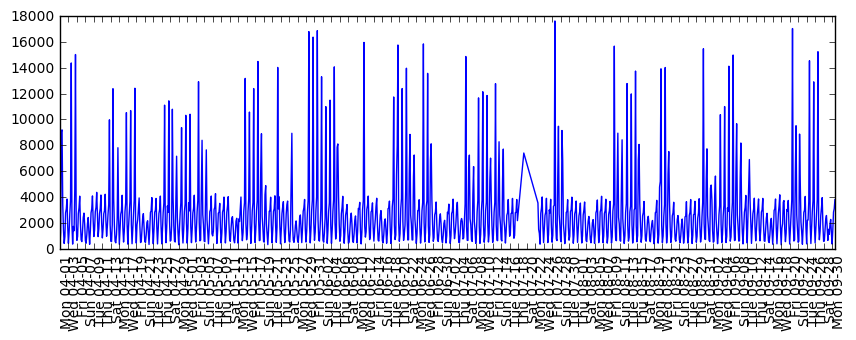

In [21]:
#Plot data

xticks = pd.date_range(start = turnstile_exits_resampled.index.min(), \
                       end =  turnstile_exits_resampled.index.max(), \
                       freq='2D')

plt.figure(figsize=(10,3))
plt.xticks(xticks,xticks.strftime("%a %m-%d"),rotation=90, ha="left")
plt.plot(turnstile_exits_resampled, linewidth=1)

In [22]:
#Examine a small irregular period of the data

turnstile_exits_resampled['20130715':'20130722']

DATETIME
2013-07-15 00:00:00   1602.00
2013-07-15 04:00:00    428.00
2013-07-15 08:00:00   1288.00
2013-07-15 12:00:00   2574.00
2013-07-15 16:00:00   2775.00
2013-07-15 20:00:00   3796.00
2013-07-16 00:00:00   2192.00
2013-07-16 04:00:00    955.00
2013-07-16 08:00:00   1178.00
2013-07-16 12:00:00   2722.00
2013-07-16 16:00:00   2742.00
2013-07-16 20:00:00   3882.00
2013-07-17 00:00:00   2259.00
2013-07-17 04:00:00    800.00
2013-07-17 08:00:00   1019.00
2013-07-17 12:00:00   2777.00
2013-07-17 16:00:00   2799.00
2013-07-17 20:00:00   3799.00
2013-07-18 00:00:00   2164.00
2013-07-19 12:00:00   7397.00
2013-07-22 20:00:00   3532.00
Name: EXITS, dtype: float64

In [23]:
#It turns out that the "irregular" period on the figure accurately represents the data in the
#original data provided.  In most cases (except the one observation removed above), it is not
#possible to conclude whether the data is erroneous and should be removed or accurate.  Accordingly
#this data is left in.

In [24]:
season_2013_df = season_2013_df.resample('4H',closed='right').sum()

In [25]:
season_2013_df.head()

,EXITS,ENTRIES
DATETIME,,
2013-04-01 04:00:00,317.00,308.00
2013-04-01 08:00:00,1209.00,4031.00
2013-04-01 12:00:00,9059.00,5702.00
2013-04-01 16:00:00,9191.00,10895.00
2013-04-01 20:00:00,3356.00,17855.00


In [26]:
#Add categorical indicators to dataframe showing 1) if a home game took place and 2) the opposing team

#Import Yankee Home Game Indicator

home_games_df = pd.read_csv('YankeesHomeGames2013.csv')
home_games_df['Date'] = pd.to_datetime(home_games_df['Date'], errors='coerce')
home_games_df['Date'] = home_games_df['Date'].map(lambda x: x.strftime('%m-%d-%Y'))
home_games_dict = dict(zip(list(home_games_df['Date']), list(home_games_df['Opponent'])))

In [27]:
home_games_dict

{'04-01-2013': 'BOS',
 '04-03-2013': 'BOS',
 '04-04-2013': 'BOS',
 '04-12-2013': 'BAL',
 '04-13-2013': 'BAL',
 '04-14-2013': 'BAL',
 '04-16-2013': 'ARI',
 '04-17-2013': 'ARI',
 '04-18-2013': 'ARI',
 '04-25-2013': 'TOR',
 '04-26-2013': 'TOR',
 '04-27-2013': 'TOR',
 '04-28-2013': 'TOR',
 '04-29-2013': 'HOU',
 '04-30-2013': 'HOU',
 '05-01-2013': 'HOU',
 '05-03-2013': 'OAK',
 '05-04-2013': 'OAK',
 '05-05-2013': 'OAK',
 '05-14-2013': 'SEA',
 '05-15-2013': 'SEA',
 '05-16-2013': 'SEA',
 '05-17-2013': 'TOR',
 '05-18-2013': 'TOR',
 '05-29-2013': 'NYM',
 '05-30-2013': 'NYM',
 '05-31-2013': 'BOS',
 '06-01-2013': 'BOS',
 '06-02-2013': 'BOS',
 '06-03-2013': 'CLE',
 '06-04-2013': 'CLE',
 '06-05-2013': 'CLE',
 '06-19-2013': 'LAD',
 '06-20-2013': 'TBR',
 '06-21-2013': 'TBR',
 '06-22-2013': 'TBR',
 '06-23-2013': 'TBR',
 '06-25-2013': 'TEX',
 '06-26-2013': 'TEX',
 '06-27-2013': 'TEX',
 '07-05-2013': 'BAL',
 '07-06-2013': 'BAL',
 '07-07-2013': 'BAL',
 '07-08-2013': 'KCR',
 '07-09-2013': 'KCR',
 '07-10-20

In [28]:
#Create the factor variable columns for home game indicator and team

season_2013_df['HOMEGAME'] = 0
season_2013_df['TEAM'] = 'NoGame'

In [29]:
#Iterate through the HOMEGAME and TEAM colunms and set value to '1' for times 12, 16, and 20 hour
#observations (you would likely not have fans showing up at 0, 4, or 8 hours) in the HOMEGAME
#column.  Set the TEAM column for those time observations to the opposing team

pd.options.mode.chained_assignment = None  # default='warn'

for date in range(0,len(season_2013_df.index)-1):
    if home_games_dict.get((season_2013_df.index[date].strftime('%m-%d-%Y')),'None') != 'None':
        if ((season_2013_df.index[date].hour == 12) | (season_2013_df.index[date].hour == 16) | \
            (season_2013_df.index[date].hour == 20) ):
                season_2013_df['HOMEGAME'][date] = 1
                season_2013_df['TEAM'][date] = home_games_dict[season_2013_df.index[date].strftime('%m-%d-%Y')]


In [30]:
season_2013_df.head()

,EXITS,ENTRIES,HOMEGAME,TEAM
DATETIME,,,,
2013-04-01 04:00:00,317.00,308.00,0,NoGame
2013-04-01 08:00:00,1209.00,4031.00,0,NoGame
2013-04-01 12:00:00,9059.00,5702.00,1,BOS
2013-04-01 16:00:00,9191.00,10895.00,1,BOS
2013-04-01 20:00:00,3356.00,17855.00,1,BOS


In [31]:
#Use Pandas label encoder function to change team strings to integer values.  This will allow
#for processing in sklearn.ensemble Random Forest Regressor

teams = season_2013_df['TEAM'].unique()
le = preprocessing.LabelEncoder()
le.fit(teams)
print pd.DataFrame({'Teams':le.classes_})
season_2013_df['TEAM'] = le.transform(season_2013_df['TEAM']) 


     Teams
0      ARI
1      BAL
2      BOS
3      CHW
4      CLE
5      DET
6      HOU
7      KCR
8      LAA
9      LAD
10     MIN
11     NYM
12  NoGame
13     OAK
14     SEA
15     SFG
16     TBR
17     TEX
18     TOR


In [32]:
#Drop observations with Null values

season_2013_df = season_2013_df[pd.notnull(season_2013_df['EXITS'])]

In [33]:
season_2013_df.shape

(1069, 4)

In [34]:
#Split dataframes into arrays so we can construct an array of lists containing values of observations
#for processing by Scikit Learn Ensemble Random Forest regressor

y = season_2013_df['EXITS'].values.ravel()
season_2013_df = season_2013_df.drop('EXITS',axis=1)
X_rf = np.hstack([season_2013_df.index.dayofweek.reshape(-1,1).astype(int), \
                                 season_2013_df.index.hour.reshape(-1,1).astype(int), \
                                 season_2013_df['HOMEGAME'].reshape(-1,1).astype(int), \
                                 season_2013_df['ENTRIES'].reshape(-1,1), \
                                 season_2013_df['TEAM'].reshape(-1,1.).astype(int)])

C:\Users\Matt\Anaconda2\lib\site-packages\pandas\core\series.py:851: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return self._values.reshape(shape, **kwargs)


In [35]:
X_rf[:5]

array([[  0.00000000e+00,   4.00000000e+00,   0.00000000e+00,
          3.08000000e+02,   1.20000000e+01],
       [  0.00000000e+00,   8.00000000e+00,   0.00000000e+00,
          4.03100000e+03,   1.20000000e+01],
       [  0.00000000e+00,   1.20000000e+01,   1.00000000e+00,
          5.70200000e+03,   2.00000000e+00],
       [  0.00000000e+00,   1.60000000e+01,   1.00000000e+00,
          1.08950000e+04,   2.00000000e+00],
       [  0.00000000e+00,   2.00000000e+01,   1.00000000e+00,
          1.78550000e+04,   2.00000000e+00]])

In [36]:
#check for erroneous (outlying) entry values.  Iterate through the array of lists and identify
#index number and values above 25000

outlier_entry_list = dict()
for i in range(0,len(X_rf)):
    outlier_entries = X_rf[i][3]
    if outlier_entries >= 25000:
        outlier_entry_list[i] = outlier_entries

In [37]:
outlier_entry_list

{649: 114013.0}

In [38]:
X_rf[649]

array([  0.00000000e+00,   1.60000000e+01,   0.00000000e+00,
         1.14013000e+05,   1.20000000e+01])

In [39]:
#Remove the outlying entry item (list) and corresponding date item for subsequent plot

X_rf = np.delete(X_rf,649,axis=0)

y = np.delete(y,649,axis=0)

In [40]:
#Create a split point using 80 percent of the data for training and 20 percent for testing.

n_train = int(round(len(X_rf) * .8))

In [41]:
#Split features into training and test set.

X_train, X_test = X_rf[:n_train], X_rf[ n_train:]

In [42]:
#Split target data into training and test set.

y_train, y_test = y[:n_train],y[n_train:]

In [43]:
#Fit a Random Forest model with 100 tree models to the data

from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=100, random_state=0)

fitted_random_forest = random_forest.fit(X_train, y_train)

In [44]:
print("training-set R^2: {:.2f}".format(fitted_random_forest.score(X_train, y_train)))

training-set R^2: 0.97


In [45]:
print("test-set R^2: {:.2f}".format(fitted_random_forest.score(X_test,y_test)))

test-set R^2: 0.86


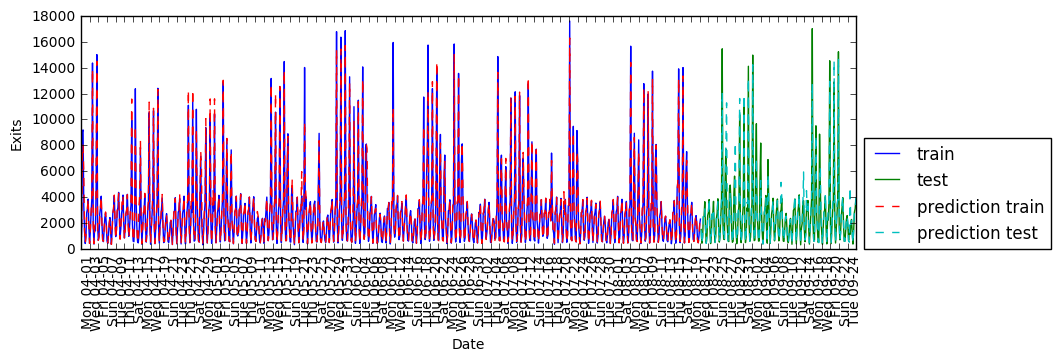

In [46]:
#Plot actual and predicted Yankee Stadium turnstile values

X = season_2013_df.index.strftime("%s").reshape(-1,1)
y_pred = fitted_random_forest.predict(X_test)
y_pred_train = fitted_random_forest.predict(X_train)
plt.figure(figsize=(10,3))
plt.xticks(range(0, len(X), 12), xticks.strftime("%a %m-%d"), rotation=90,ha="left")
plt.plot(range(n_train), y_train, label="train")
plt.plot(range(n_train, len(y_test) + n_train), y_test, '-' ,label="test")
plt.plot(range(n_train), y_pred_train, '--', label="prediction train")

plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="prediction test")
plt.legend(loc=(1.01,0))
plt.xlabel("Date")
plt.ylabel("Exits")

In [47]:
#Find and print the exit volume (predicted and actual) on 9/6/2013 at 8 pm

idx = season_2013_df.index
y_pred_idx = idx[(len(idx))-len(y_pred):len(idx)]
test_df = pd.DataFrame({'test_actual': y_test, 'test_pred': y_pred},index=y_pred_idx)
test_df['20130906'].at_time('20:00:00')

,test_actual,test_pred
DATETIME,,
2013-09-06 20:00:00,14984.00,14230.76


In [48]:
#Examine feature importance

features = ['DAYOFWEEK','HOUR','HOMEGAME','ENTRIES','TEAM']

importances = fitted_random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in fitted_random_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. HOMEGAME (0.370853)
2. ENTRIES (0.270005)
3. HOUR (0.262567)
4. DAYOFWEEK (0.067456)
5. TEAM (0.029119)


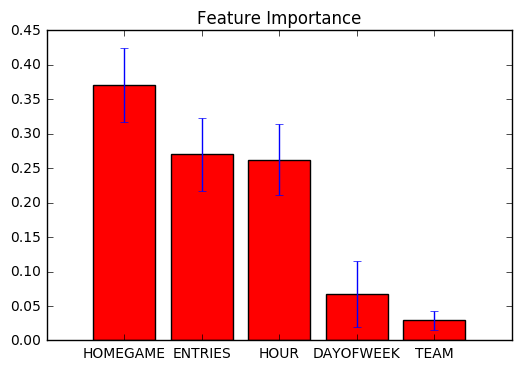

In [49]:
#Plot feature importance

plot_features = []
for f in range(X_train.shape[1]):
     plot_features.append(features[indices[f]])

plt.figure()
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), plot_features)
plt.xlim([-1, X_train.shape[1]])
plt.show()